<div align="center">

### Report By    
### Muhammad Talha
### Matriculation No.: 23131067

</div>


# Report: Analysis of Domestic Flights to USA Cities

## Main Question

**How does the number of flights to a city in the USA relate to the city type, and what are the top cities and routes?**


## Introduction

This project is about analyzing data of flights between major USA cities, in order to see how attributes related to cities relate to number of flights coming to that city, and what are the top destinations and routes. There can be further analytics related to time of flights and network analysis. The project would also involve Data Engineering through ETL (Extract, Transform, Load), Data Modeling and Data Warehousing concepts. Two datasets will be used including a CSV of flights in 2020 and a Parquet file of Cities information from 2020.

## Motivation

In This analysis we plan to figure out why certain cities have more flights. By looking at different city characteristics, we want to understand which factors contribute to the number of flights a city receives. Knowing the most popular cities and routes helps travelers make better choices, and it helps allocate resources effectively. Analyzing trends over time and understanding the network of flights provides a dynamic view. Data engineering ensures we explore the data meaningfully. This information is valuable for city planning, aviation industry planning, and making informed decisions for everyone involved.


## Goals

Following are the goals for this project: 

1. **Identify Trends:** Explore the data to identify any repeating patterns in the number of flights to USA cities and their relationship with city types.

2. **City Type Analysis:** Understanding how different types of cities influence the number of incoming flights.

3. **Top Cities and Routes:** Determining the top cities that receive the most flights and identify popular flight routes.

4. **Temporal Analysis:** Analyzing the time-related aspects of flights to uncover trends and patterns.

5. **Network Analysis:** Exploring the network of flights between cities/states to gain insights into connectivity.

6. **Data Visualization:** Create informative graphs and charts for easy understanding and interpretation.


## Datasources

### Data Source #1: Air Flight Dataset
- **Metadata URL:** [Flight Dataset Metadata](https://www.kaggle.com/datasets/brandonconrady/top-100-us-cities-by-population)
- **Data URL:** [Flight Dataset](https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022?select=Combined_Flights_2020.parquet)
- **Data Type:** Parquet
- **License:** CC0: Public Domain
- **Description:** This dataset encompasses all flight information, including details on cancellations and delays by airline. The data spans from January 2018, extracted from the "On-Time" database of the TranStats data library.

### Data Source #2: Top 100 US Cities by Population
- **Metadata URL:** [City Population Dataset Metadata](https://www.kaggle.com/datasets/brandonconrady/top-100-us-cities-by-population)
- **Data URL:** [City Population Dataset](https://www.kaggle.com/datasets/brandonconrady/top-100-us-cities-by-population)
- **Data Type:** CSV
- **License:** CC0: Public Domain
- **Description:** The dataset includes information on the top 100 US cities by population, derived from Wikipedia. It lists each city, its rank based on 2020 population, area data, and populations in both 2020 and 2010.


## Data Transformation

### 1. Kaggle Token Download

We start by downloading a Kaggle API token which allows us to access and download datasets from Kaggle.

### 2. CSV File Download

Next, we download two different datasets from Kaggle

1. **Population Dataset:**
- This dataset has info on the top 100 U.S. cities by population. We download a CSV file and load it into a table called `population_df`.

2. **Flights Dataset:**
- This dataset, stored as a Parquet file, contains details about flights in 2020, including cancellations and delays by airline. - We downloaded it, unzipped it, and loaded it into a table called `flights_df`.

### 3. Population DataFrame Cleaning

- Now, we clean up the `population_df` table. We remove unnecessary columns in the dataset.
- finally get rid of any missing or repeated data to keep things neat with the help of `General_Cleaning` function.

### 4. Flights DataFrame Cleaning and SQLite Database Creation

- We start by selecting specific columns from the dataset that are relevant to our analysis, including flight details, dates, and locations.

- The `General_Cleaning` function is then applied to remove any repeated or missing data, ensuring our dataset is clean and tidy.

- We filter the dataset to include only flights related to U.S. states. Both the origin and destination states are checked against the states present in the `population_df`.

- We exclude canceled flights (`Cancelled` not equal to `True`) from our dataset, as they won't contribute to our analysis.

- Unnecessary columns like 'Origin', 'Dest', 'DistanceGroup', 'Cancelled', and 'Year' are dropped from the dataset.

- We clean up city names by removing extra information after commas using regular expressions.

- Similar to state filtering, we make sure the dataset only includes flights related to U.S. cities present in the `population_df`.

- A new column, 'Same_State', is added to indicate whether the origin and destination states are the same.

- We categorize flight distances into 'low', 'medium', and 'high' bins based on predefined distance intervals.

- The 'FlightDate' column is converted to string format, and a new 'FlightId' column is created as an index starting from 1.

- If needed, columns can be rearranged. In this case, 'FlightId' is set as the first column.

- Finally, we use the `Create_SQL_Table` method to create an 'Flights' table in our SQLite database, with 'FlightId' as the primary key.

With these steps, our `flights_df` is thoroughly cleaned and transformed, ready for further analysis. We make flight table as our fact table.


### 5. Dimension Tables Creation

Here we create dimention tables 

1. **City Table:** 
- This table holds unique city info from the `population_df`. 
- it conists of some important feature columns from `population_df`
- Finally, we use the `Create_SQL_Table` method to create a 'Cities' table in our SQLite database, with 'City' the name as the primary key.
- next we delete the dataframe to save space.

2. **Month Table:** 
- This is a simple table listing all the months.
- we use the `Create_SQL_Table` method to create a `Months` table in our SQLite database, with `Month` the name as the primary key.
- next we delete the dataframe to save space.

3. **State Origin Destination Table:**
- This table holds unique `OriginStateName` from the `flight_df`.
- We the use `pd.merge` to merge relative values of the `OriginStateName` such as the `DestStateName` and so.
- we use the `Create_SQL_Table` method to create a `State_Origin_Dest` table in our SQLite database.
- next we delete the dataframe to save space.

3. **City Origin Destination Table:**
- This table holds unique `OriginCityName` from the `flight_df`.
- We the use `pd.merge` to merge relative values of the `OriginCityName` such as the `DestCityName` and so.
- we use the `Create_SQL_Table` method to create a `City_Origin_Dest` table in our SQLite database.
- next we delete the dataframe to save space.

## Analysis

### Importing Libraries

In [1]:
import os
import sqlite3
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

### Reading Data From The Database

In [47]:
current_dir = os.getcwd()
data_dir = os.path.join(os.path.dirname(current_dir), 'data')
os.makedirs(data_dir, exist_ok=True)
db_path = os.path.join(data_dir,'Database.sqlite')
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

### Creating Function to implement SQL queries on the Database

In [48]:
def sql_to_pandas(cur,query):
    cur.execute(query,[])
    cols = []
    for elt in cur.description:
        cols.append( elt[0] )
    return pd.DataFrame(data=cur.fetchall(), columns=cols )

### Number of Flights per City

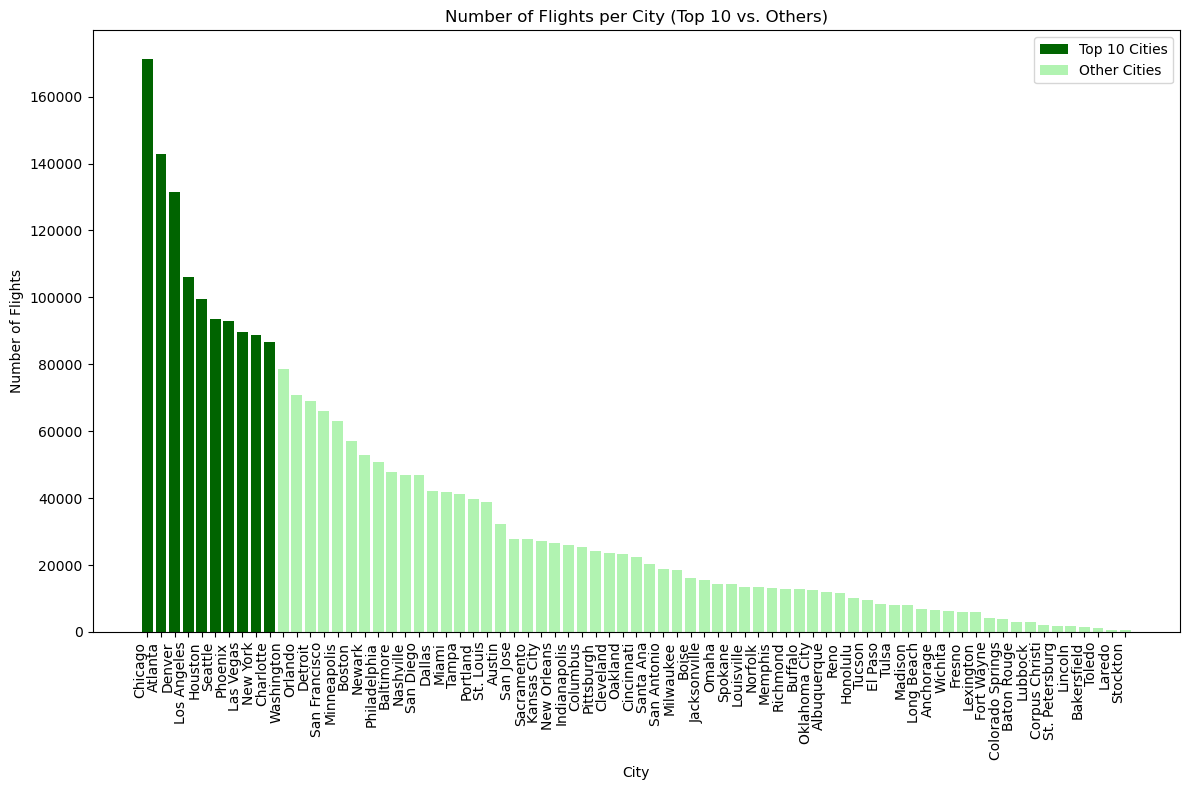

In [46]:
flights_per_city_df = sql_to_pandas(cursor,'select City, Count(*) as NumberOfFlights from Cities,Flights  where City=DestCityName group by DestCityName order by NumberOfFlights desc;')
city_names = flights_per_city_df['city']
number_of_flights = flights_per_city_df['NumberOfFlights']
flights_per_city_df = flights_per_city_df.sort_values(by='NumberOfFlights', ascending=False)
top_10_cities = flights_per_city_df.head(10)
other_cities = flights_per_city_df.iloc[10:]
plt.figure(figsize=(12, 8))
plt.bar(top_10_cities['city'], top_10_cities['NumberOfFlights'], color='darkgreen', label='Top 10 Cities')
plt.bar(other_cities['city'], other_cities['NumberOfFlights'], color='lightgreen', label='Other Cities', alpha=0.7)
plt.xlabel('City')
plt.ylabel('Number of Flights')
plt.title('Number of Flights per City (Top 10 vs. Others)')
plt.xticks(rotation=90, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


### Conclusion:

Looking at the data about flights, we can see that some cities have a lot more flights than others. Chicago is the busiest city, with 171,257 flights. Atlanta, Denver, Los Angeles, and Houston are also busy places for flights.

The stacked bar chart helps us compare the top 10 cities with the rest. It's clear that these top cities have way more flights compared to others.

This information is helpful for understanding which cities play a major role in air travel. We can dig deeper to find out why these cities are so important for flights, considering factors like location, population, and economic activity. The chart gives us a good starting point for exploring more about how air travel works in our dataset.


## City Attributes vs. Number of Flights

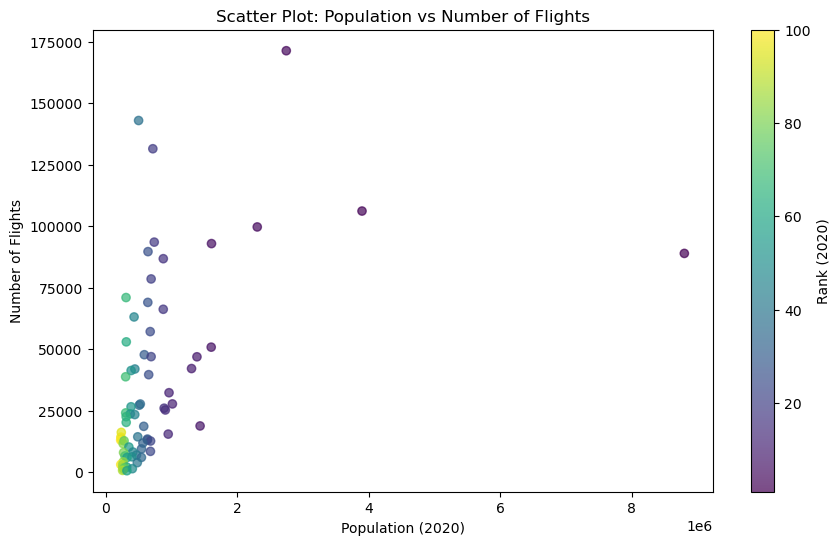

In [60]:
cities_df = sql_to_pandas(cursor,'select rank_2020, largest_city_in_state,population_2020 ,federal_capital,state_capital, Count(*) as NumberOfFlights from Cities,Flights  where City=DestCityName group by DestCityName order by NumberOfFlights desc;')
plt.figure(figsize=(10, 6))
plt.scatter(cities_df['population_2020'], cities_df['NumberOfFlights'], c=cities_df['rank_2020'], cmap='viridis', alpha=0.7)
plt.xlabel('Population (2020)')
plt.ylabel('Number of Flights')
plt.title('Scatter Plot: Population vs Number of Flights')
cbar = plt.colorbar()
cbar.set_label('Rank (2020)')
plt.show()

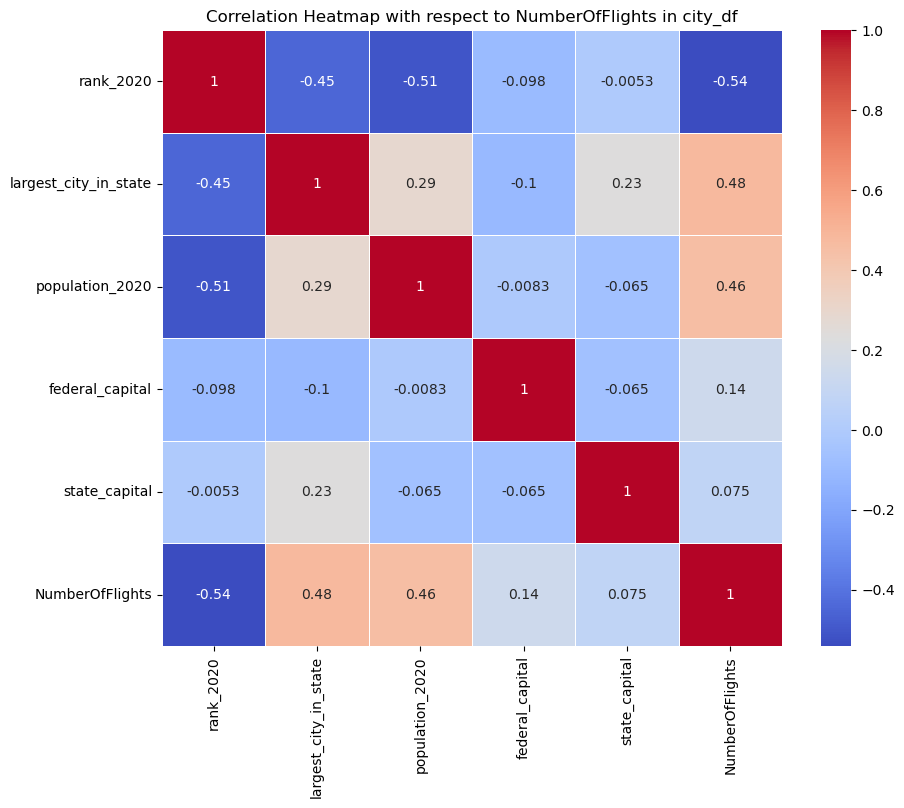

In [56]:
correlation_matrix = cities_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap with respect to NumberOfFlights in city_df')
plt.show()

### Major Relations Analysis

#### 1. Rank vs. Population, Largest City in State, NumberOfFlights

- The Rank is negatively correlated with:
  - Population: -0.51
  - Largest City in State: -0.45
  - NumberOfFlights: -0.54

  This indicates that:
  - The higher the population, the larger the city, and the more flights a city has, the lower its rank will be.
  - If the city is the largest in the state, it is also likely to have a lower rank. __PLEASE NOTE THAT LOWER RANK IS BETTER RANK__

#### 2. Largest City in State vs. Population, State Capital, NumberOfFlights

- The Largest City in State is positively correlated with:
  - Population: 0.29
  - State Capital: 0.23
  - NumberOfFlights: 0.48

  This implies that:
  - Cities that are the largest in their respective states tend to have higher populations and more flights.
  - There is a correlation between being the largest city in the state and being the state capital.

#### 3. Population vs. NumberOfFlights

- Population is negatively correlated with NumberOfFlights: -0.46

  This suggests that:
  - Cities with larger populations tend to have fewer flights.

#### 4. Federal Capital vs. NumberOfFlights

- The Federal Capital is positively correlated with NumberOfFlights: 0.14

  This implies that:
  - Cities that serve as the federal capital tend to have more flights.



## Time Analysis

In [124]:
flights_x_df= sql_to_pandas(cursor,'select* from flights;')
flights_x_df['FlightDate']=pd.to_datetime(flights_df['FlightDate'])
flight_x_df['FlightMonth'] = flight_x_df['FlightDate'].dt.month
result_df = flight_x_df.groupby(['DestStateName', 'FlightMonth']).size().reset_index(name='NoOfFlights')

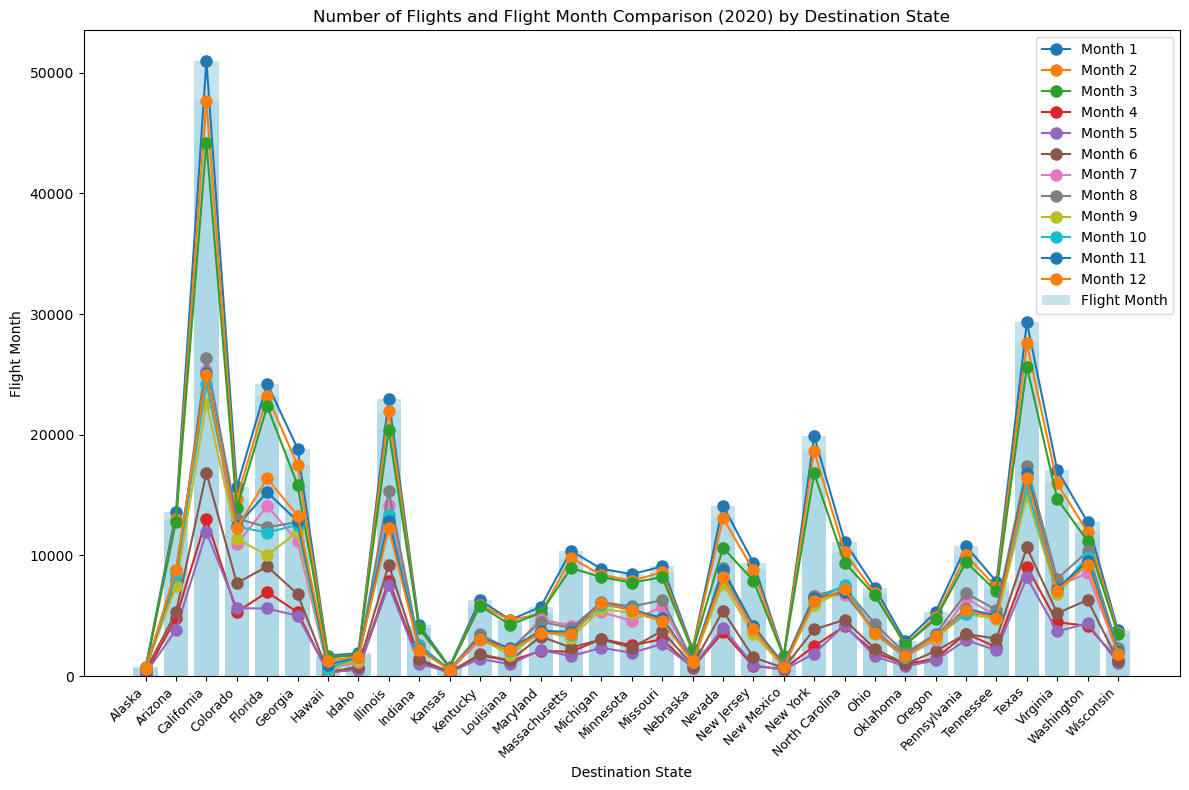

In [125]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.bar(result_df['DestStateName'], result_df['NoOfFlights'], alpha=0.7, color='lightblue', label='Flight Month')
ax1.set_xlabel('Destination State')
ax1.set_ylabel('Flight Month', color='black')
ax1.tick_params('y', colors='black')
for month in range(1, 13):
    mask_month = result_df['FlightMonth'] == month
    ax1.plot(result_df['DestStateName'][mask_month], result_df['NoOfFlights'][mask_month], marker='o', markersize=8, label=f'Month {month}')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper right')

for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment('right')
    tick.set_fontsize(9)

plt.title('Number of Flights and Flight Month Comparison (2020) by Destination State')
plt.tight_layout()
plt.show()


In [129]:
flight_x_df.columns

Index(['FlightId', 'FlightDate', 'Flight_Number_Operating_Airline',
       'OriginState', 'DestState', 'Operating_Airline', 'OriginCityName',
       'OriginStateName', 'DestCityName', 'DestStateName', 'AirTime',
       'Distance', 'Same_State', 'FlightMonth'],
      dtype='object')

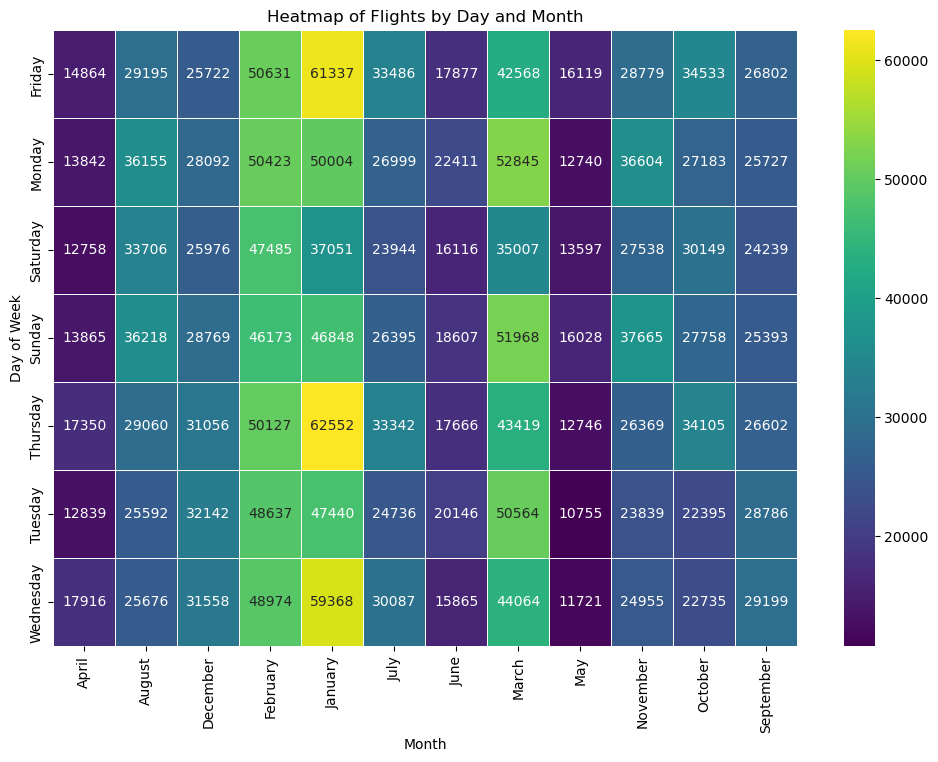

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming flights_x_df is your DataFrame with the specified columns
# Ensure 'FlightDate' is in datetime format
flights_x_df['FlightDate'] = pd.to_datetime(flights_x_df['FlightDate'])

# Extract day and month information
flights_x_df['Day'] = flights_x_df['FlightDate'].dt.day_name()
flights_x_df['Month'] = flights_x_df['FlightDate'].dt.month_name()

# Create a pivot table for the heatmap
heatmap_data = flights_x_df.pivot_table(index='Day', columns='Month', values='FlightId', aggfunc='count', fill_value=0)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='g', linewidths=.5)
plt.title('Heatmap of Flights by Day and Month')
plt.xlabel('Month')
plt.ylabel('Day of Week')
plt.show()


### Flight Analysis Summary

#### Busiest Day and Month
- **Busiest Day:** Thursday
- **Busiest Month:** January

#### Observations
- Thursday is the busiest day for flights, possibly due to increased business travel.
- January stands out as the busiest month, suggesting higher travel demand, potentially influenced by holidays.

## Data Engineering and ETL

Foreign keys for Flights: []
Foreign keys for Cities: []
Foreign keys for States: [(0, 0, 'Cities', 'state', 'state', 'NO ACTION', 'NO ACTION', 'NONE')]
Foreign keys for State_Origin_Dest: [(0, 0, 'Cities', 'DestStateName', 'state', 'NO ACTION', 'NO ACTION', 'NONE'), (1, 0, 'Cities', 'OriginStateName', 'state', 'NO ACTION', 'NO ACTION', 'NONE')]
Foreign keys for City_Origin_Dest: [(0, 0, 'Cities', 'DestCityName', 'city', 'NO ACTION', 'NO ACTION', 'NONE'), (1, 0, 'Cities', 'OriginCityName', 'city', 'NO ACTION', 'NO ACTION', 'NONE')]


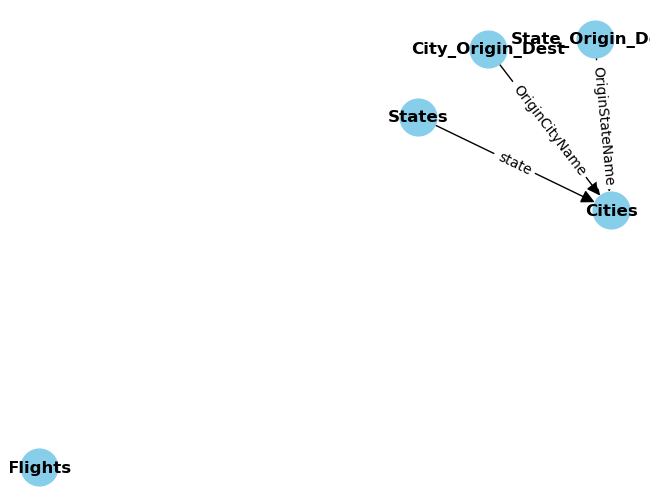

In [50]:
import sqlite3
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image

def get_table_names(cursor):
    """Get a list of all table names in the database."""
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    return [table[0] for table in cursor.fetchall()]

# Get all table names
tables = get_table_names(cursor)

# Create a directed graph using networkx
G = nx.DiGraph()

# Add nodes for each table
for table in tables:
    G.add_node(table, shape='box')

# Query the SQLite database for foreign key relationships
for table in tables:
    cursor.execute(f"PRAGMA foreign_key_list({table});")
    foreign_keys = cursor.fetchall()

    # Print foreign key information for debugging
    print(f"Foreign keys for {table}: {foreign_keys}")

    for fk in foreign_keys:
        G.add_edge(table, fk[2], label=fk[3])

# Draw the graph
output_file = 'flow_diagram.png'
pos = nx.spring_layout(G)  # You can adjust the layout algorithm as needed
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', arrowsize=20)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.savefig(output_file)
plt.show()

following is the flow diagram of the DataBase, where Flights is the Fact Table and Cities is the Dimention Table

## State Names and Number of Flights in comparison with State Names and their Population 

In [37]:
import plotly.graph_objects as go
import plotly.express as px

# Fetch data from the database
flights_data = sql_to_pandas(cursor, 'select DestStateName, OriginState, DestState, Count(*) as NumberOfFlights from Flights group by DestStateName;')
population_data = sql_to_pandas(cursor, 'SELECT state, sum(pop_density_sqkm) as pop_density_sqkm,sum(population_2020) as population_2020 from cities group by state')

# Merge the two DataFrames
result_df = pd.merge(flights_data, population_data[['state', 'population_2020','pop_density_sqkm']], left_on='DestStateName', right_on='state', how='inner')
result_df = result_df.drop('state', axis=1)

# Create choropleth map for Flights Traffic
fig1 = px.choropleth(result_df,
                     locations='DestState',
                     locationmode="USA-states",
                     color='NumberOfFlights',
                     hover_name='DestStateName',
                     color_continuous_scale='thermal',
                     range_color=[result_df['NumberOfFlights'].min(), result_df['NumberOfFlights'].max()],
                     title='Flights Traffic',
                     scope='usa'  # Set the focus point to the USA
)

# Create choropleth map for Population
fig2 = px.choropleth(result_df,
                     locations='DestState',
                     locationmode="USA-states",
                     color='population_2020',
                     hover_name='DestStateName',
                     color_continuous_scale='thermal',
                     range_color=[result_df['population_2020'].min(), result_df['population_2020'].max()],
                     title='Population',
                     scope='usa'  # Set the focus point to the USA
)

# Show the figures side by side
fig1.show()
fig2.show()


## State Connections Map of Flights

In [38]:
State_Origin_Dest_df = sql_to_pandas(cursor,'select* from State_Origin_Dest')
fig = px.line_geo(State_Origin_Dest_df,
                  locations='OriginState',
                  locationmode='USA-states',
                  title='State Connections Map',
                  color='Distance',  # Color based on Distance
                  labels={'Distance': 'Distance'},
                  hover_name='Origin_Destination',  # Display information on hover
                  line_group='DestState',  # Connect states based on destination
                  projection='natural earth')
fig.show()

Following are all the unique connections of flights for states

## Flights Traffic Heatmap by City in 2020

In [40]:
cities_df = sql_to_pandas(cursor,'select City,Longitude, Latitude , Count(*) as NumberOfFlights from Cities,Flights  where City=DestCityName group by DestCityName order by NumberOfFlights desc;')
#Converting Lat and Long from String to Float
def dms_to_decimal(coord):
    degrees, rest = coord.split('°')
    minutes, direction = rest.split('′')
    degrees = float(degrees)
    minutes = float(minutes)
    sign = -1 if direction.endswith('S') or direction.endswith('W') else 1
    return sign * (degrees + minutes / 60)
cities_df['Latitude_decimal'] = cities_df['latitude'].apply(dms_to_decimal)
cities_df['Longitude_decimal'] = cities_df['longitude'].apply(dms_to_decimal)
fig = px.density_mapbox(cities_df,
                        lat='Latitude_decimal',
                        lon='Longitude_decimal',
                        z='NumberOfFlights',
                        radius=10,
                        center=dict(lat=37.0902, lon=-95.7129),  # Center of the USA
                        mapbox_style="carto-positron",
                        title='Flights Traffic Heatmap by City in 2020',
                        zoom=3,
                        color_continuous_scale='thermal',
                        hover_name='city',
                        hover_data={'city': True, 'Latitude_decimal': ':.4f', 'Longitude_decimal': ':.4f', 'NumberOfFlights': ':,d'},range_color=(585, 171257))
fig.show()


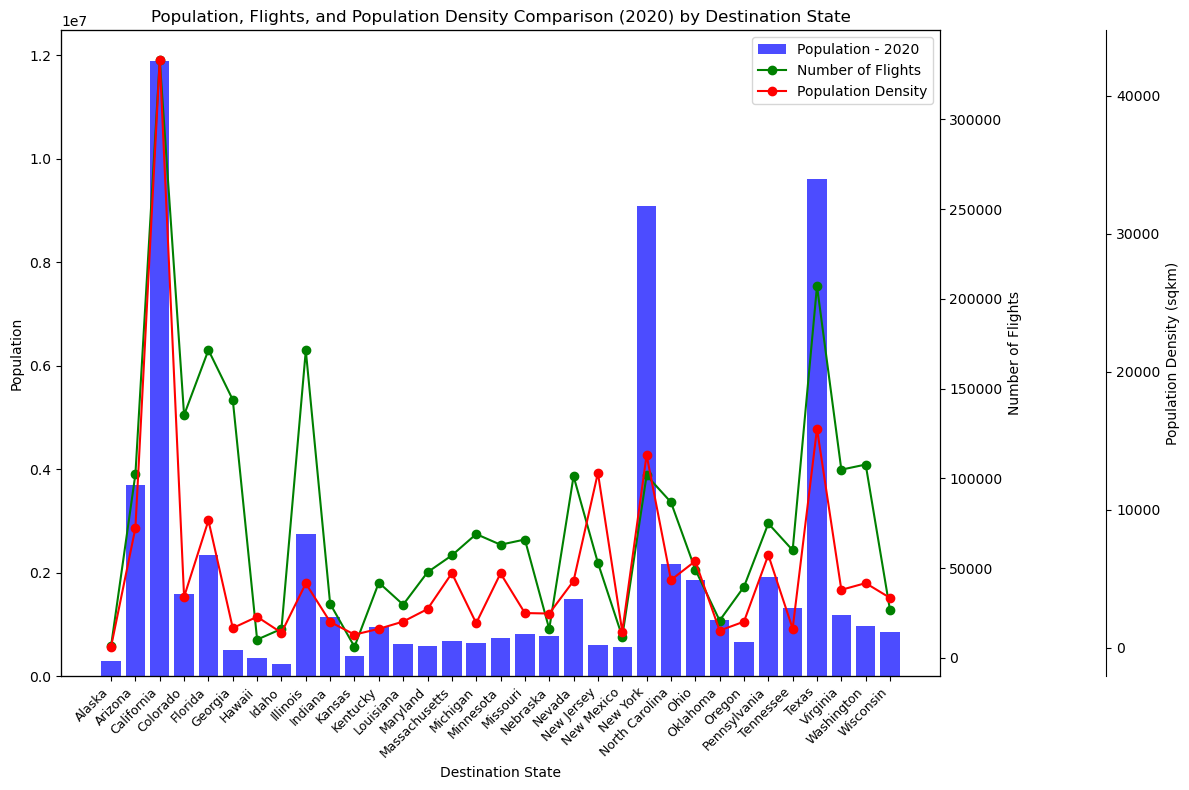

In [45]:
### Comparison of Population, Flights, and Population Density by Destination State

import matplotlib.pyplot as plt

# Assuming result_df is the DataFrame containing your data
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot population on the first y-axis
ax1.bar(result_df['DestStateName'], result_df['population_2020'], alpha=0.7, color='blue', label='Population - 2020')
ax1.set_xlabel('Destination State')
ax1.set_ylabel('Population', color='black')
ax1.tick_params('y', colors='black')

# Create a second y-axis for flight count
ax2 = ax1.twinx()
ax2.plot(result_df['DestStateName'], result_df['NumberOfFlights'], color='green', marker='o', label='Number of Flights')
ax2.set_ylabel('Number of Flights', color='black')
ax2.tick_params('y', colors='black')

# Create a third y-axis for population density
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 120))  # Adjust the position of the third y-axis
ax3.plot(result_df['DestStateName'], result_df['pop_density_sqkm'], color='red', marker='o', label='Population Density')
ax3.set_ylabel('Population Density (sqkm)', color='black')
ax3.tick_params('y', colors='black')

# Adjust legend positions to the right
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper right')

for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment('right')
    tick.set_fontsize(9)

plt.title('Population, Flights, and Population Density Comparison (2020) by Destination State')
plt.tight_layout()
plt.show()


## Conclusion

1. **Flight Insights:**
   - Cities differ in flight frequency. Chicago tops the list with 171,257 flights, followed by Atlanta, Denver, Los Angeles, and Houston. The top 10 cities clearly dominate air travel.
   - The stacked bar chart accentuates the significant gap between these top cities and others in terms of flight volume.
   - This information is vital for unraveling the factors contributing to the air travel dynamics in major cities. Factors like location, population, and economic activity play a role, and further exploration can provide a deeper understanding.

2. **Major Relations Analysis:**
   - **Rank vs. Population, Largest City, and Flights:**
      - A negative correlation exists between rank and population (-0.51), largest city in the state (-0.45), and number of flights (-0.54).
      - Higher population, larger city size, and more flights contribute to a lower rank. Note: A lower rank is favorable in this context.
   - **Largest City in State vs. Population, State Capital, and Flights:**
      - Positive correlations are found between the largest city in the state and population (0.29), state capital (0.23), and number of flights (0.48).
      - Cities that are the largest in their states tend to have higher populations and more flights. There's also a correlation between being the largest city and serving as the state capital.
   - **Population vs. Number of Flights:**
      - A negative correlation of -0.46 indicates that cities with larger populations tend to have fewer flights.
   - **Federal Capital vs. Number of Flights:**
      - A positive correlation of 0.14 suggests that cities serving as federal capitals tend to have more flights.

3. **Flight Analysis Summary:**
   - **Busiest Day and Month:**
      - **Busiest Day:** Thursday, potentially influenced by increased business travel.
      - **Busiest Month:** January, indicating higher travel demand, possibly due to holidays.

4. **Database Structure:**
   - The flow diagram illustrates the database structure, where Flights serves as the Fact Table and Cities as the Dimension Table. This setup facilitates understanding the relationships within our dataset.

In summary, our exploration of flight data highlights the prominence of specific cities in air travel. The major relations analysis unveils correlations between city attributes and flight patterns, offering valuable insights for further investigation. Understanding these dynamics is crucial for efficient planning and decision-making in the realm of air travel.
